# Deriving Offensive Line Effectiveness from Tracking Data

This is the code that accompanies my submission for the [NFL Big Data Bowl 2023](https://www.kaggle.com/code/mattlowrieds/offensive-line-effectiveness-from-tracking-data). In this notebook I look at several metrics derived from tracking data which can give insight into offensive line effectiveness in stopping a pass rush by the defense.

In [21]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from pymcdm.methods import TOPSIS
from pymcdm.helpers import rrankdata
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
games_df = pd.read_csv('games.csv')
plays_df = pd.read_csv('plays.csv')
scout_df = pd.read_csv('pffScoutingData.csv')
dfs = []
for i in range(1, 9):
    dfs.append(pd.read_csv(f'week{i}.csv'))
track_df = pd.concat(dfs, ignore_index=True)
del dfs

In [3]:
# Create a GroupBy object of all the game/play combinations which have a sack
sacks_gp_gb = scout_df.loc[scout_df['pff_sack'] == 1].groupby(['gameId', 'playId'])
# Create a GroupBy object of all the game/play combinations which have a hurry play with progress less than 1 yard
# First create a GroupBy object of all hurry game/play combinations
hurry_gp_gb = scout_df.loc[scout_df['pff_hurry'] == 1].groupby(['gameId', 'playId'])
# Next convert all game/play combinations in plays.csv to a Series of tuples
plays_gp_combos = plays_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)
# Finally lookup all hurry plays with a playResult less than 1 yard
hurry_lt1yd_gp_gb = plays_df.loc[(plays_gp_combos.isin(hurry_gp_gb.groups.keys())) &
                                 (plays_df['playResult'] < 1)].groupby(['gameId', 'playId'])

In [4]:
# Get all game/play combinations in the tracking data. We need this data as a Series
# because it needs to have the same number of rows so we can use it as a DataFrame
# filter with isin().
track_gp_combos = track_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)

In [5]:
track_sacks_df = track_df.loc[track_gp_combos.isin(sacks_gp_gb.groups.keys())]
track_nonsacks_df = track_df.loc[~track_gp_combos.isin(sacks_gp_gb.groups.keys())]
track_hurry_df = track_df.loc[track_gp_combos.isin(hurry_lt1yd_gp_gb.groups.keys())]
track_nonhurry_df = track_df.loc[~track_gp_combos.isin(hurry_lt1yd_gp_gb.groups.keys())]

In [6]:
# Get the nflId for each pass rusher and blocker in each play of every game
pass_rush_ids_gb = scout_df.loc[scout_df['pff_role'] == 'Pass Rush'].groupby(['gameId', 'playId', 'nflId'])
pass_block_ids_gb = scout_df.loc[scout_df['pff_role'] == 'Pass Block'].groupby(['gameId', 'playId', 'nflId'])

# Sack plays

In [7]:
# Create a GroupBy object of all game/play/nflId for each sack and nonsack combination
sacks_gpn_combos = track_sacks_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)
nonsacks_gpn_combos = track_nonsacks_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)

In [8]:
sacks_avg_speed = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
sacks_avg_accel = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
sacks_sum_dist = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
nonsacks_avg_speed = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
nonsacks_avg_accel = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
nonsacks_sum_dist = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()

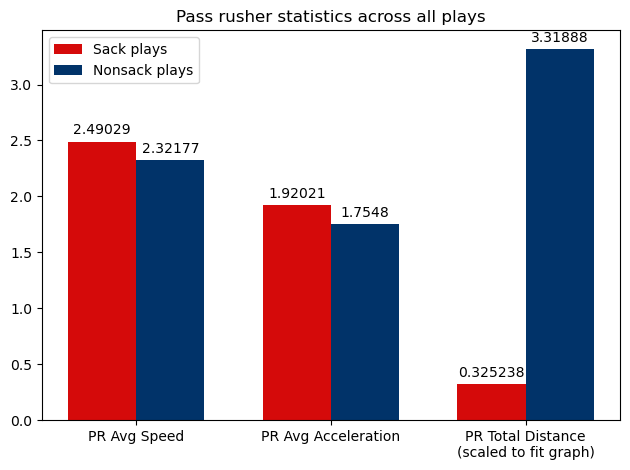

In [9]:
x_lbls = ['PR Avg Speed', 'PR Avg Acceleration', 'PR Total Distance\n(scaled to fit graph)']
x_range = np.arange(len(x_lbls))
dist_graph_scale_factor = 100000
sacks_vals = [sacks_avg_speed, sacks_avg_accel, sacks_sum_dist/dist_graph_scale_factor]
nonsacks_vals = [nonsacks_avg_speed, nonsacks_avg_accel, nonsacks_sum_dist/dist_graph_scale_factor]

bar_width = 0.35
fig, ax = plt.subplots()
bars_sacks = ax.bar(x_range - bar_width/2, sacks_vals, bar_width, label='Sack plays', color='#D50A0A')
bars_nonsacks = ax.bar(x_range + bar_width/2, nonsacks_vals, bar_width, label='Nonsack plays', color='#013369')
ax.bar_label(bars_sacks, padding=3)
ax.bar_label(bars_nonsacks, padding=3)
ax.set_xticks(x_range, x_lbls)
ax.legend()
plt.title('Pass rusher statistics across all plays')
fig.tight_layout()
plt.show()

# Hurry plays

In [10]:
hurry_gpn_combos = track_hurry_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)
nonhurry_gpn_combos = track_nonhurry_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)

In [11]:
hurry_avg_speed = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
hurry_avg_accel = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
hurry_sum_dist = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
nonhurry_avg_speed = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
nonhurry_avg_accel = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
nonhurry_sum_dist = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()

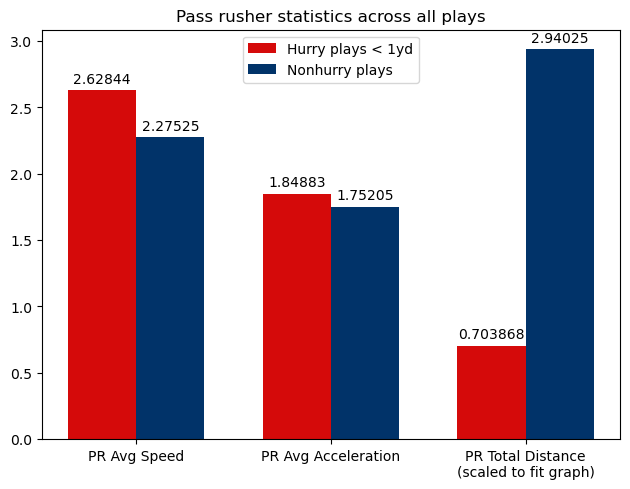

In [12]:
x_lbls = ['PR Avg Speed', 'PR Avg Acceleration', 'PR Total Distance\n(scaled to fit graph)']
x_range = np.arange(len(x_lbls))
dist_graph_scale_factor = 100000
hurry_vals = [hurry_avg_speed, hurry_avg_accel, hurry_sum_dist/dist_graph_scale_factor]
nonhurry_vals = [nonhurry_avg_speed, nonhurry_avg_accel, nonhurry_sum_dist/dist_graph_scale_factor]

bar_width = 0.35
fig, ax = plt.subplots()
bars_hurry = ax.bar(x_range - bar_width/2, hurry_vals, bar_width, label='Hurry plays < 1yd', color='#D50A0A')
bars_nonhurry = ax.bar(x_range + bar_width/2, nonhurry_vals, bar_width, label='Nonhurry plays', color='#013369')
ax.bar_label(bars_hurry, padding=3)
ax.bar_label(bars_nonhurry, padding=3)
ax.set_xticks(x_range, x_lbls)
ax.legend(loc='upper center')
fig.tight_layout()
plt.title('Pass rusher statistics across all plays')
plt.show()

# Per team metrics

In [13]:
def collect_offensive_team_metrics(r):
    gid, pid = r
    # Get an array of nflIds for the pass rushers for this play
    pass_rush_ids = scout_df.loc[(scout_df['gameId'] == gid) &
                                 (scout_df['playId'] == pid) &
                                 (scout_df['pff_role'] == 'Pass Rush')]['nflId'].to_numpy()
    # Get the team of pass rushers. This is returned as array but should only contain one team.
    pr_team = ['']
    if len(pass_rush_ids):
        pr_team = track_df.loc[(track_df['gameId'] == gid) &
                               (track_df['playId'] == pid) &
                               (track_df['nflId'] == pass_rush_ids[0])]['team'].to_numpy()
    # Get the string value of the defensive team
    defense_team = ''
    if len(pr_team):
        defense_team = np.unique(pr_team)[0]
    # Get the average speed and acceleration of the pass rushers as a Series
    pr_speed_accel_sr = track_df.loc[(track_df['gameId'] == gid) &
                                     (track_df['playId'] == pid) &
                                     (track_df['nflId'].isin(pass_rush_ids))][['s', 'a']].mean()
    # Get the total distance of the pass rushers as a Series
    pr_dist_sr = track_df.loc[(track_df['gameId'] == gid) &
                              (track_df['playId'] == pid) &
                              (track_df['nflId'].isin(pass_rush_ids))][['dis']].sum()
    #pr_dist.rename('dis')
    #pr_speed_accel['dis'] = pr_dist.values
    # Get both teams in this game to figure out which team is offense
    game_teams = games_df.loc[games_df['gameId'] == gid][['homeTeamAbbr', 'visitorTeamAbbr']].values
    offense_team = ''
    if len(game_teams):
        for gt in game_teams[0]:
            if gt != defense_team:
                offense_team = gt
    return pd.concat([pd.Series(np.unique(offense_team), index=['team']), pr_speed_accel_sr, pr_dist_sr])

gps = track_gp_combos.drop_duplicates()
offense_team_metrics_gp_df = gps.parallel_apply(collect_offensive_team_metrics)

In [14]:
offensive_team_stats = {}
for t in track_df['team'].unique():
    if t != 'football':
        avg_speed = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['s'].mean()
        avg_accel = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['a'].mean()
        sum_dist = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['dis'].sum()
        offensive_team_stats[t] = [avg_speed, avg_accel, sum_dist]


# Ranking

In [15]:
# Use TOPSIS ranking to sort the teams
topsis = TOPSIS()

team_lookup = []
stat_rank = []
for team, m in offensive_team_stats.items():
    if math.isnan(m[0]) or math.isnan(m[1]) or math.isnan(m[2]):
        continue
    team_lookup.append(team)
    stat_rank.append(np.array([m[0], m[1], m[2]]))

weights = np.array([1.0, 1.0, 1.0])
ordering = np.array([-1, -1, 1])
top_sort = TOPSIS()(np.array(stat_rank), weights, ordering)
ranking = rrankdata(top_sort)

In [16]:
order_table = {}
for i, r in enumerate(ranking):
    order_table[team_lookup[int(r)-1]] = stat_rank[i]

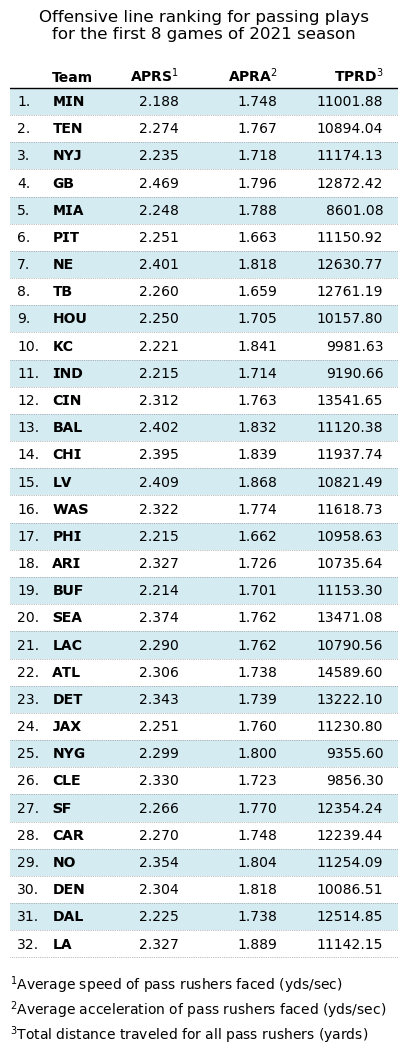

In [23]:
# Create a table of the results
fig, ax = plt.subplots(figsize=(5, 12))
rows = 32
cols = 5
ax.set_ylim(-1, rows+1)
ax.set_xlim(0, cols+0.5)

for i, (t, v) in enumerate(order_table.items()):
    ax.text(x=0.1, y=rows-1-i, s=f'{i+1}.', va='center', ha='left')
    ax.text(x=0.6, y=rows-1-i, s=t, va='center', ha='left', fontfamily='Verdana', fontweight='bold')
    ax.text(x=2.4, y=rows-1-i, s='{:.3f}'.format(v[0]), va='center', ha='right')
    ax.text(x=3.8, y=rows-1-i, s='{:.3f}'.format(v[1]), va='center', ha='right')
    ax.text(x=5.3, y=rows-1-i, s='{:.2f}'.format(v[2]), va='center', ha='right')

# Column headers
ax.text(x=0.6, y=31.75, s='Team', weight='bold', ha='left')
ax.text(x=2.4, y=31.75, s='APRS$^1$', weight='bold', ha='right')
ax.text(x=3.8, y=31.75, s='APRA$^2$', weight='bold', ha='right')
ax.text(x=5.3, y=31.75, s='TPRD$^3$', weight='bold', ha='right')
ax.text(x=0, y=-3.5, s=('$^1$Average speed of pass rushers faced (yds/sec)\n'
                        '$^2$Average acceleration of pass rushers faced (yds/sec)\n'
                        '$^3$Total distance traveled for all pass rushers (yards)'))

for y in range(0, rows, 2):
    row_bg = patches.Rectangle((0, 0.5+y), 6.0, 1.0, ec='none', fc='lightblue', alpha=0.5)
    ax.add_patch(row_bg)

for r in range(rows):
    ax.plot([0, cols+1], [r-0.5, r-0.5], ls=':', lw='0.5', c='grey')
ax.plot([0, cols+1], [31.5, 31.5], lw='1', c='black')
ax.axis('off')
plt.title('Offensive line ranking for passing plays\nfor the first 8 games of 2021 season')
plt.show()